In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

In [3]:
# From Covid Tracking API
# https://covidtracking.com/api/
api_us = 'https://covidtracking.com/api/us/daily'
api_states = 'https://covidtracking.com/api/states/daily'

# https://github.com/COVID19Tracking/associated-data
f_pop = 'associated-data/us_census_data/us_census_2018_population_estimates_states.csv'

In [4]:
df_us = pd.read_json(api_us)
df_states = pd.read_json(api_states)
df_pop = pd.read_csv(f_pop)

In [5]:
df_us.shape

(33, 24)

In [6]:
df_states.shape

(1709, 25)

In [7]:
df_pop.head()

,state,state_name,geo_id,population,pop_density
0,AL,Alabama,1,4887871,96.509389
1,AK,Alaska,2,737438,1.291523
2,AZ,Arizona,4,7171646,63.135855
3,AR,Arkansas,5,3013825,57.919684
4,CA,California,6,39557045,253.906502


In [8]:
df_us['date'] = df_us['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df_states['date'] = df_states['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [9]:
df_us.sort_values(by=['date']).tail()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
4,2020-04-01,56,210816,939190,59669,16223.0,31142.0,3837.0,4270.0,71.0,...,4700,31142.0,1209675,1150006,1150006,954.0,4482.0,74989.0,26133.0,101122.0
3,2020-04-02,56,239099,1028649,62101,17157.0,32649.0,4264.0,541.0,67.0,...,5784,32649.0,1329849,1267748,1267748,1084.0,1507.0,89459.0,28283.0,117742.0
2,2020-04-03,56,271988,1124874,61980,19926.0,35991.0,4686.0,593.0,70.0,...,6962,35991.0,1458842,1396862,1396862,1178.0,3342.0,96225.0,32889.0,129114.0
1,2020-04-04,56,305755,1318052,15573,22158.0,38402.0,5207.0,691.0,656.0,...,8314,38402.0,1639380,1623807,1623807,1352.0,2411.0,193178.0,33767.0,226945.0
0,2020-04-05,56,332308,1429742,17307,23061.0,41372.0,5497.0,913.0,612.0,...,9498,41372.0,1779357,1762050,1762050,1184.0,2970.0,111690.0,26553.0,138243.0


In [10]:
df_states.sort_values(by=['date']).tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
32,2020-04-05,NE,363.0,5558.0,12.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5933,5921,5921,31,2.0,0.0,500.0,42.0,542.0
31,2020-04-05,ND,207.0,6580.0,NaN,20.0,31.0,NaN,NaN,NaN,...,31.0,6787,6787,6787,38,0.0,1.0,559.0,21.0,580.0
30,2020-04-05,NC,2585.0,37460.0,NaN,261.0,NaN,NaN,NaN,NaN,...,NaN,40045,40045,40045,37,7.0,0.0,1089.0,183.0,1272.0
28,2020-04-05,MS,1638.0,5580.0,NaN,NaN,475.0,NaN,NaN,NaN,...,475.0,7218,7218,7218,28,8.0,39.0,447.0,183.0,630.0
0,2020-04-05,AK,185.0,6099.0,NaN,NaN,20.0,NaN,NaN,NaN,...,20.0,6284,6284,6284,2,1.0,4.0,230.0,14.0,244.0


In [11]:
# Merge in population data
df_states = pd.merge(df_states, df_pop, on='state')

# Calculate positive per million
df_states['pos_rate'] = df_states['positive'] / (df_states['population'] / 1e6)

# Calculate hospitalized per million
df_states['hosp_rate'] = df_states['hospitalized'] / (df_states['population'] / 1e6)

# Calculate deaths per million
df_states['death_rate'] = df_states['death'] / (df_states['population'] / 1e6)

# Calculate total tests
df_states['total'] = df_states['positive'] + df_states['negative']

# Calculate percent of tests that are positive
df_states['positive_rate'] = df_states['positive'] / df_states['total']

# Calculate tests per million people
df_states['test_rate'] = df_states['total'] / (df_states['population'] / 1e6)

# Calculate 7-day average deaths
df_states['death_7dma'] = df_states['death'].rolling(window=7).mean()

In [12]:
df_states.tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,state_name,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
1620,2020-03-11,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1621,2020-03-10,WY,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,0.0,NaN
1622,2020-03-09,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1623,2020-03-08,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1624,2020-03-07,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN


In [13]:
df_states.describe()

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,totalTestResultsIncrease,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
count,1625.000000,1520.000000,451.000000,129.000000,482.000000,39.000000,72.000000,37.000000,47.000000,155.000000,...,1573.000000,1625.000000,1.625000e+03,1604.000000,1625.000000,482.000000,968.000000,1515.000000,1520.000000,660.000000
mean,1484.983385,7522.340132,1551.751663,1214.139535,634.921162,964.000000,307.958333,53.891892,109.404255,472.212903,...,1118.872219,29.542154,6.520604e+06,429.078684,171.250573,59.249622,6.291803,0.125922,1580.509436,45.666667
std,7216.155412,16482.694605,8781.909018,3227.794648,2715.146597,1299.216647,640.137891,127.912249,154.021266,1736.199264,...,3112.563978,16.331905,7.353765e+06,1600.045429,460.884442,141.680487,15.719327,0.139795,2281.547995,170.026278
min,0.000000,0.000000,-3.000000,2.000000,0.000000,9.000000,6.000000,4.000000,4.000000,2.000000,...,-585.000000,1.000000,5.777370e+05,1.291523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,129.750000,4.000000,39.000000,25.000000,25.000000,13.250000,6.000000,9.500000,25.500000,...,19.000000,16.000000,1.805832e+06,54.955978,2.839263,11.726116,0.371249,0.046344,42.707362,2.857143
50%,105.000000,1447.500000,24.000000,75.000000,99.000000,410.000000,71.500000,21.000000,39.000000,46.000000,...,176.000000,29.000000,4.468402e+06,107.860112,31.307755,27.903542,1.867847,0.083961,505.164634,9.357143
75%,621.000000,7189.500000,123.500000,424.000000,311.750000,1436.500000,198.500000,37.000000,108.000000,115.500000,...,1014.000000,42.000000,7.535591e+06,229.511156,165.135133,52.175028,5.338612,0.152880,2392.628967,28.607143
max,122031.000000,180249.000000,64400.000000,16479.000000,28092.000000,4376.000000,3022.000000,571.000000,535.000000,12187.000000,...,78400.000000,72.000000,3.955704e+07,11490.119540,6244.483415,1437.503815,212.821386,0.891705,15468.056861,2534.428571


## California

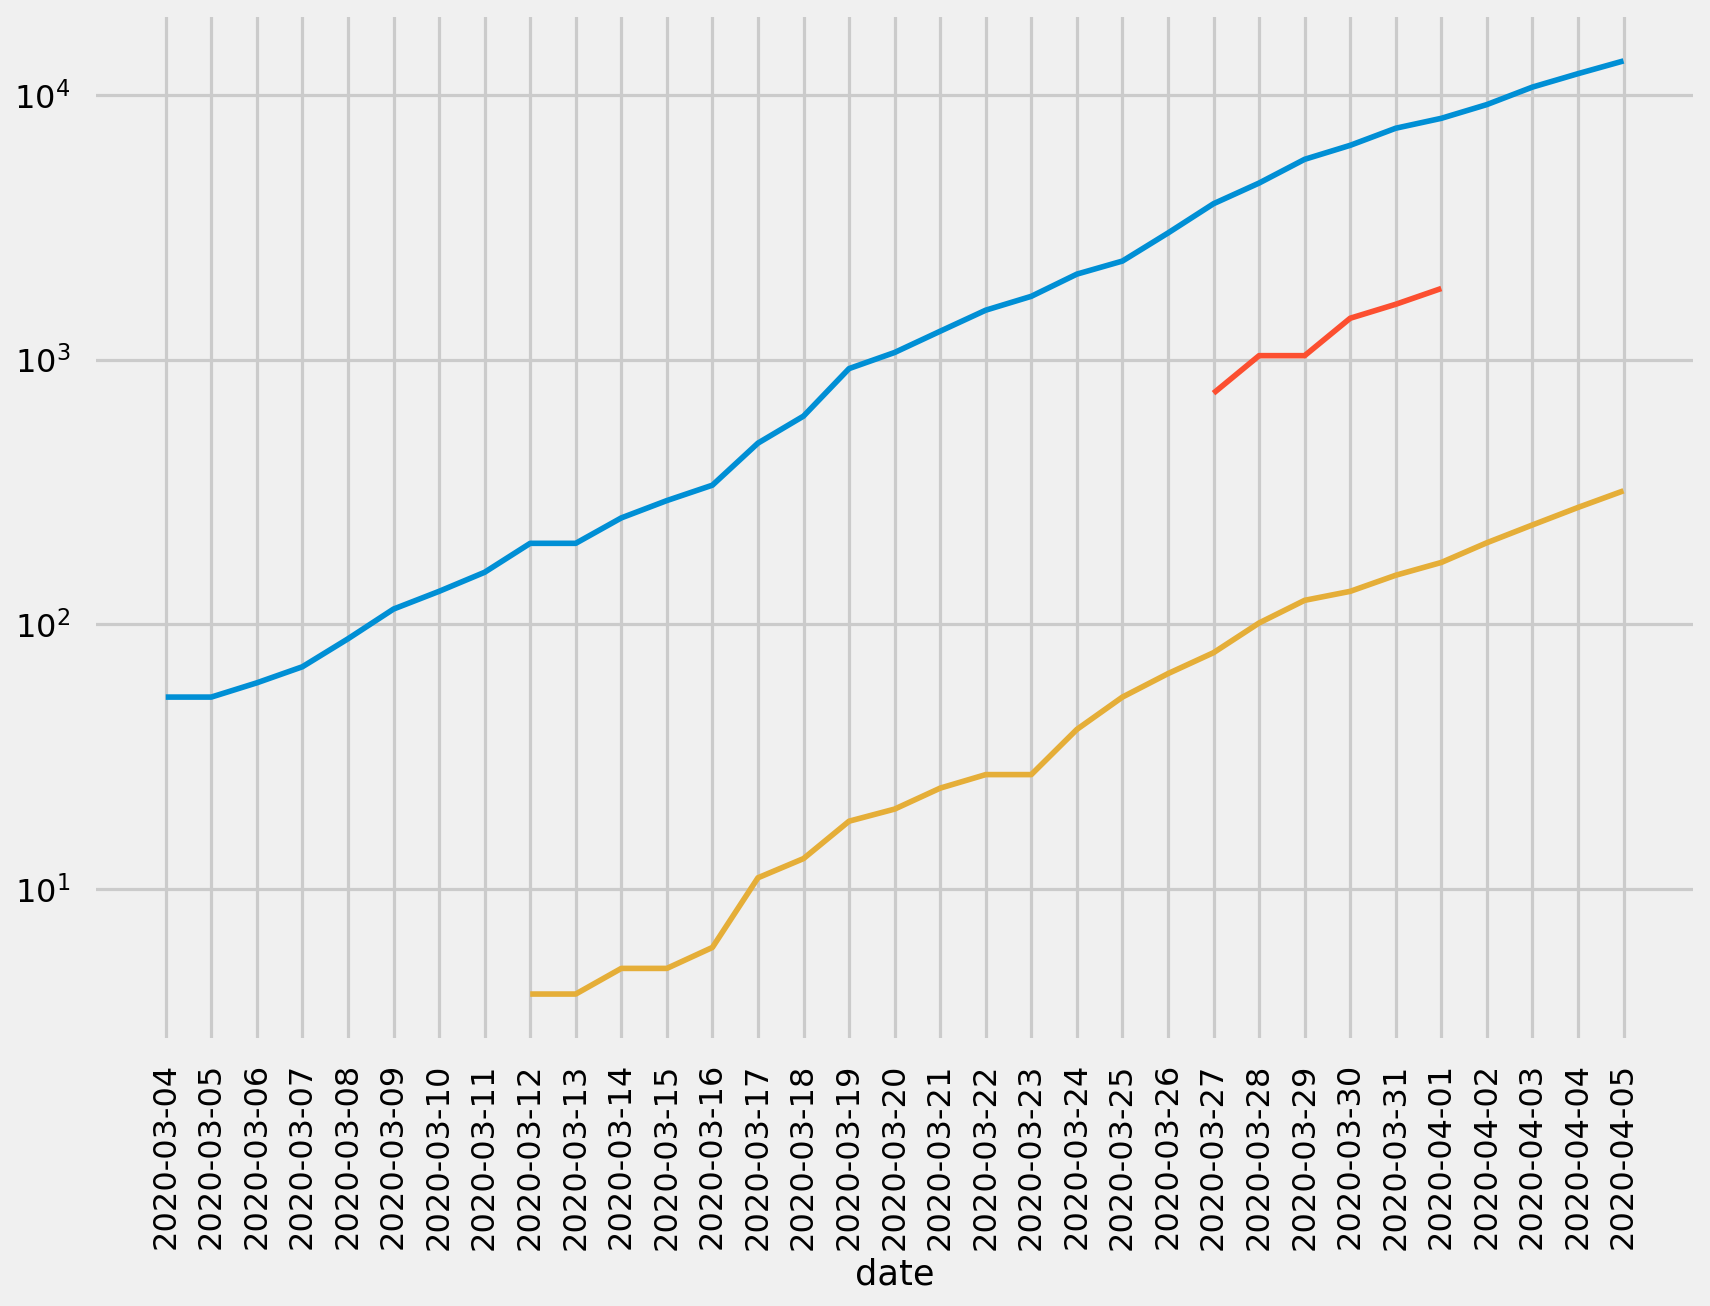

In [14]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "CA"'))
ax = sns.lineplot(x="date", y="hospitalized", 
                  data=df_states.query('state == "CA"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "CA"'))
ax.set(xticks=df_states.query('state == "CA"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

## New York

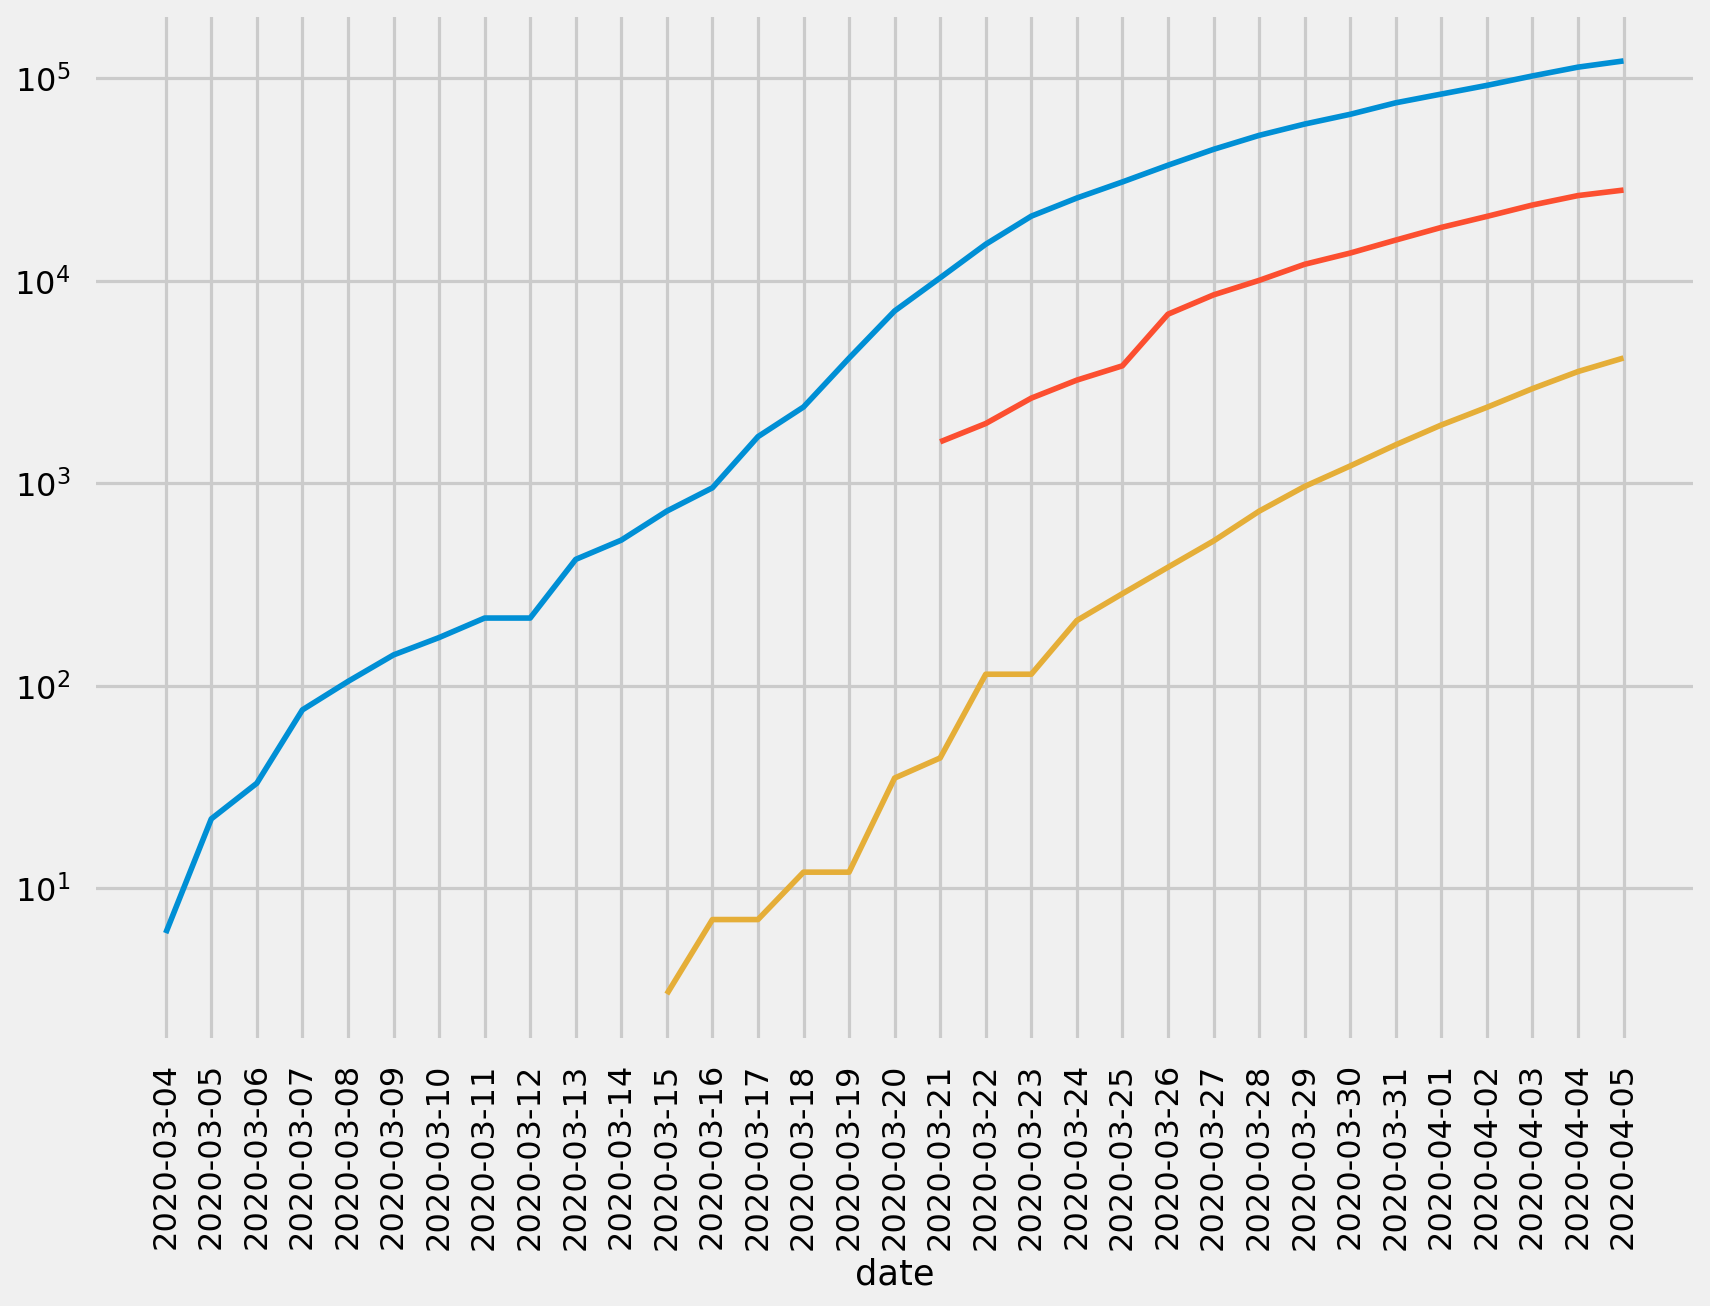

In [15]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "NY"'))
ax = sns.lineplot(x="date", y="hospitalized", 
                  data=df_states.query('state == "NY"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "NY"'))
ax.set(xticks=df_states.query('state == "NY"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

# Top 10 States by Deaths

In [16]:
latest_date = df_states['date'].max()
top_states = df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False).state.head(10).tolist()
df_top_states = df_states.query('state == @top_states')
top_states

['NY', 'NJ', 'MI', 'LA', 'CA', 'WA', 'IL', 'MA', 'FL', 'GA']

In [17]:
df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False)[['state', 'death']]

,state,death
1067,NY,4159.0
972,NJ,917.0
691,MI,617.0
566,LA,477.0
125,CA,319.0
1498,WA,310.0
440,IL,274.0
596,MA,231.0
283,FL,218.0
316,GA,211.0


In [18]:
# Deaths per million people
df_states.query('date == @latest_date').sort_values(by='death_rate', 
                                                    ascending=False)[['state', 'death_rate']]

,state,death_rate
1067,NY,212.821386
972,NJ,102.935168
566,LA,102.360998
691,MI,61.725215
190,CT,52.901685
1498,WA,41.138114
1467,VT,35.126992
596,MA,33.467837
220,DC,31.318732
1247,RI,23.644798


# Deaths

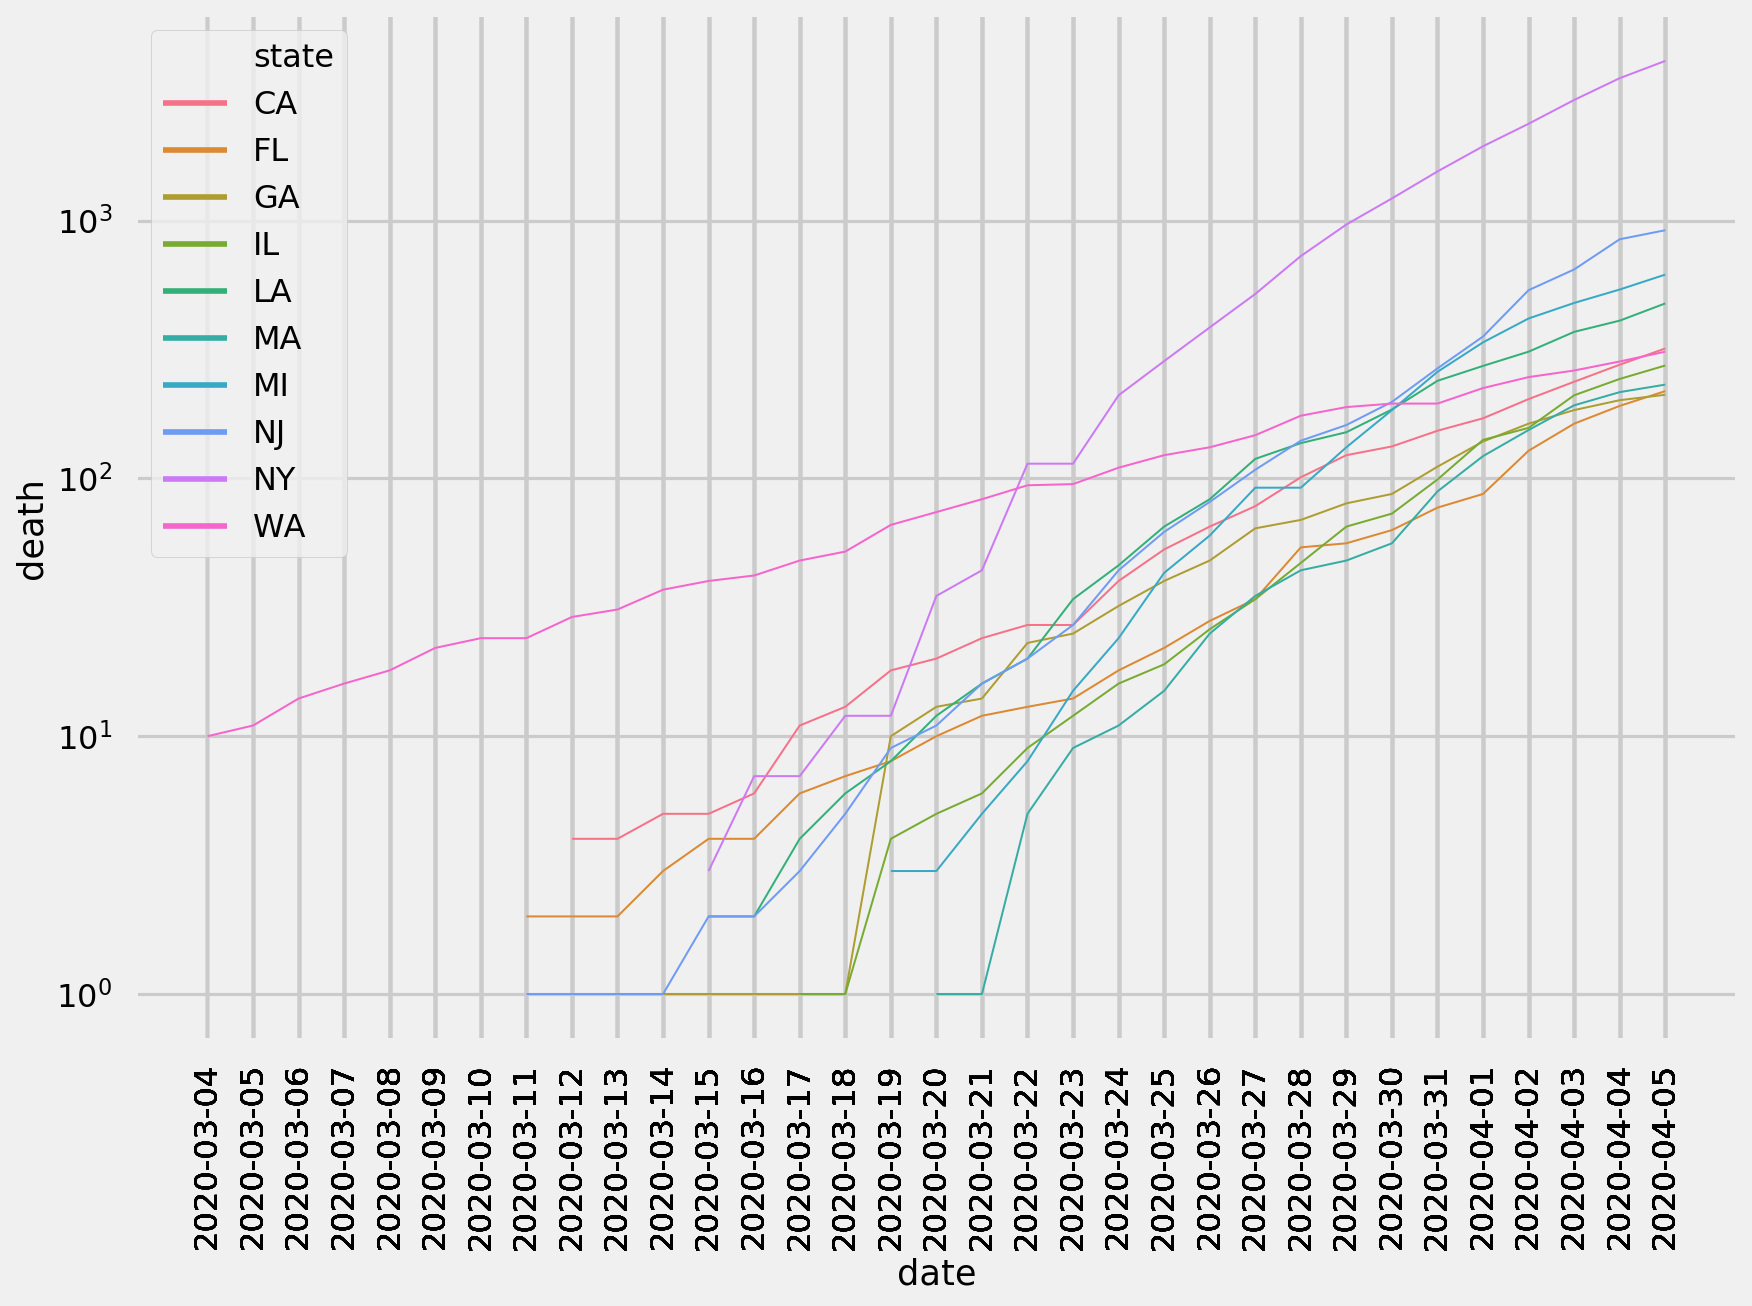

In [19]:
ax = sns.lineplot(x="date", 
                  y="death", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths (7-day Moving Average)

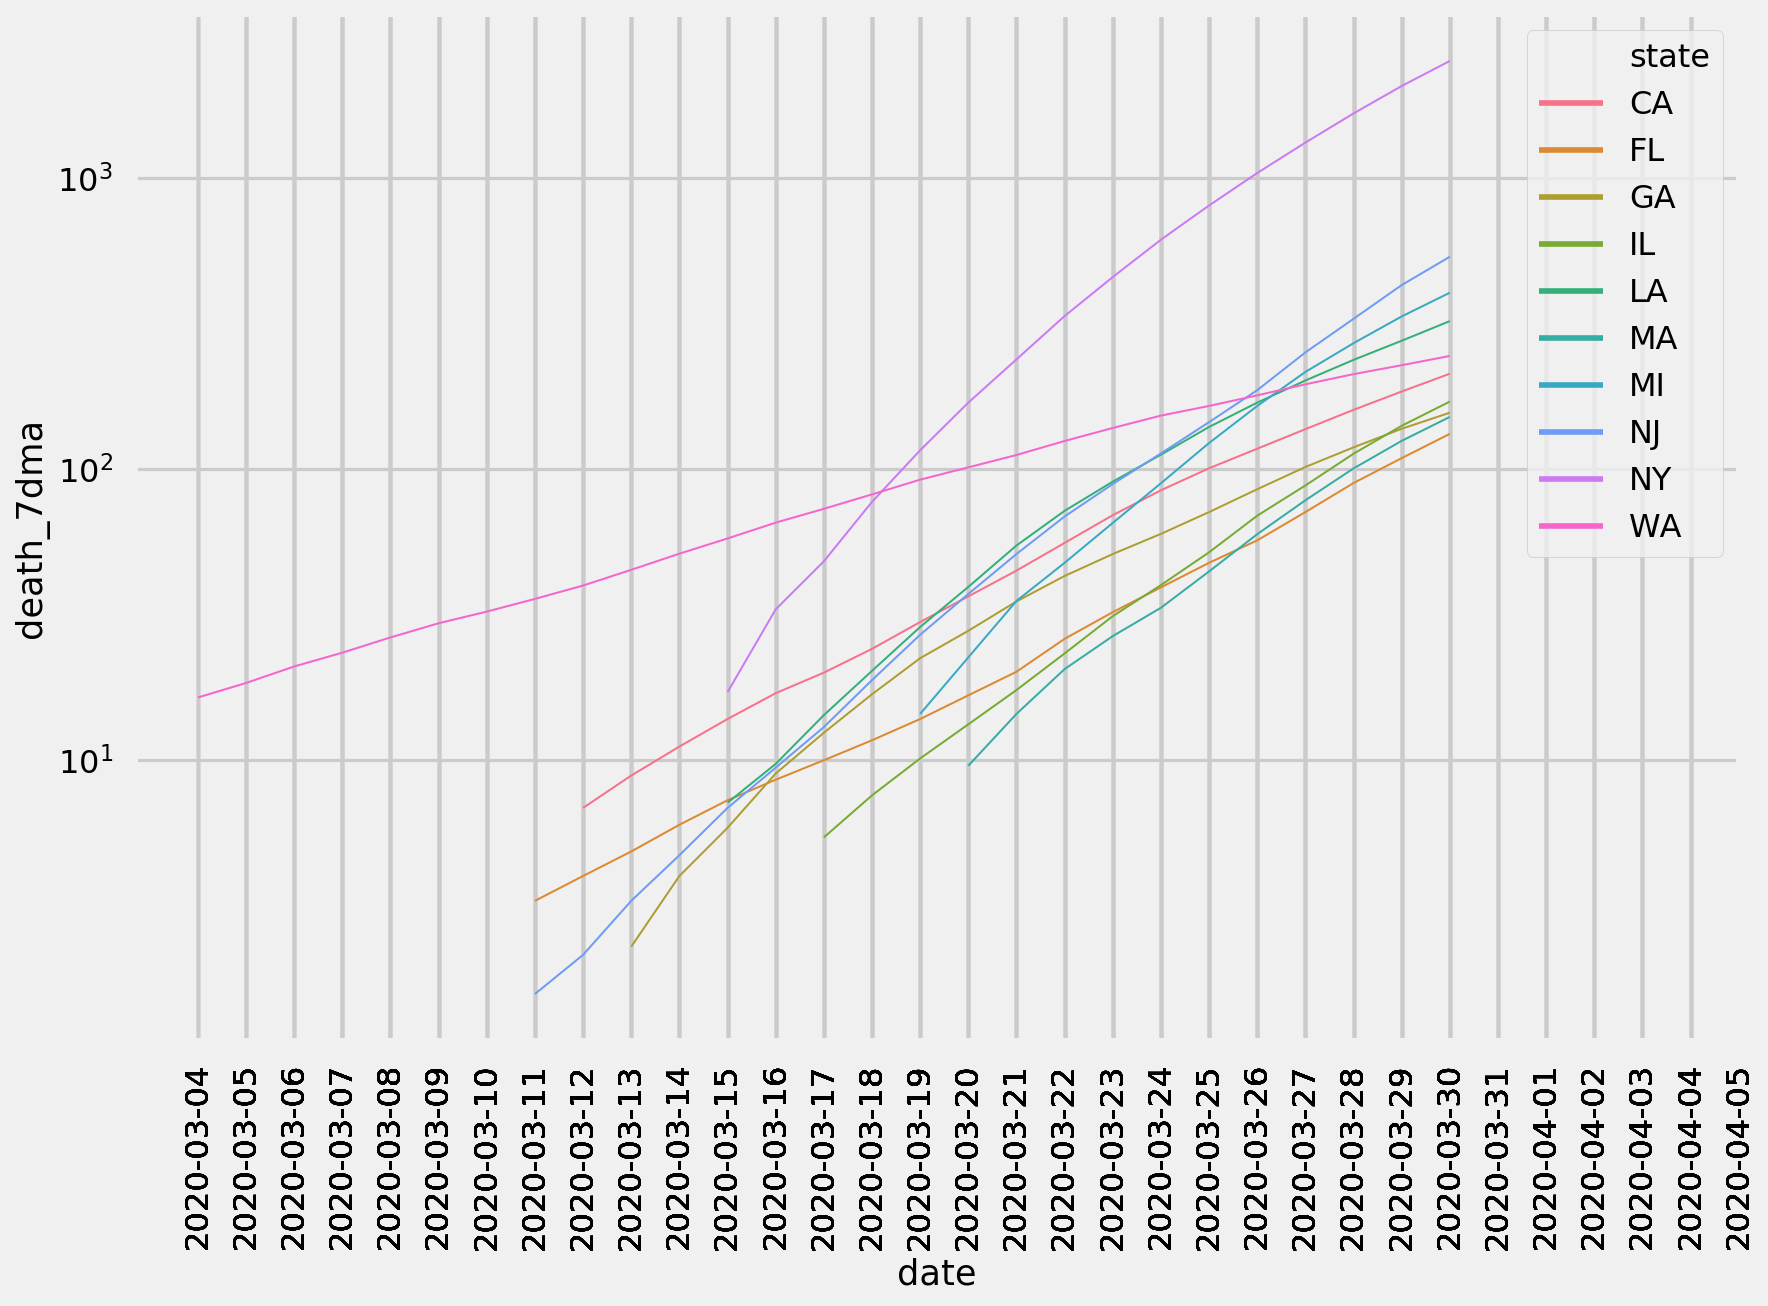

In [20]:
# TODO: index this by date first crossed 5 deaths
ax = sns.lineplot(x="date", 
                  y="death_7dma", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Positive Cases Per Million People

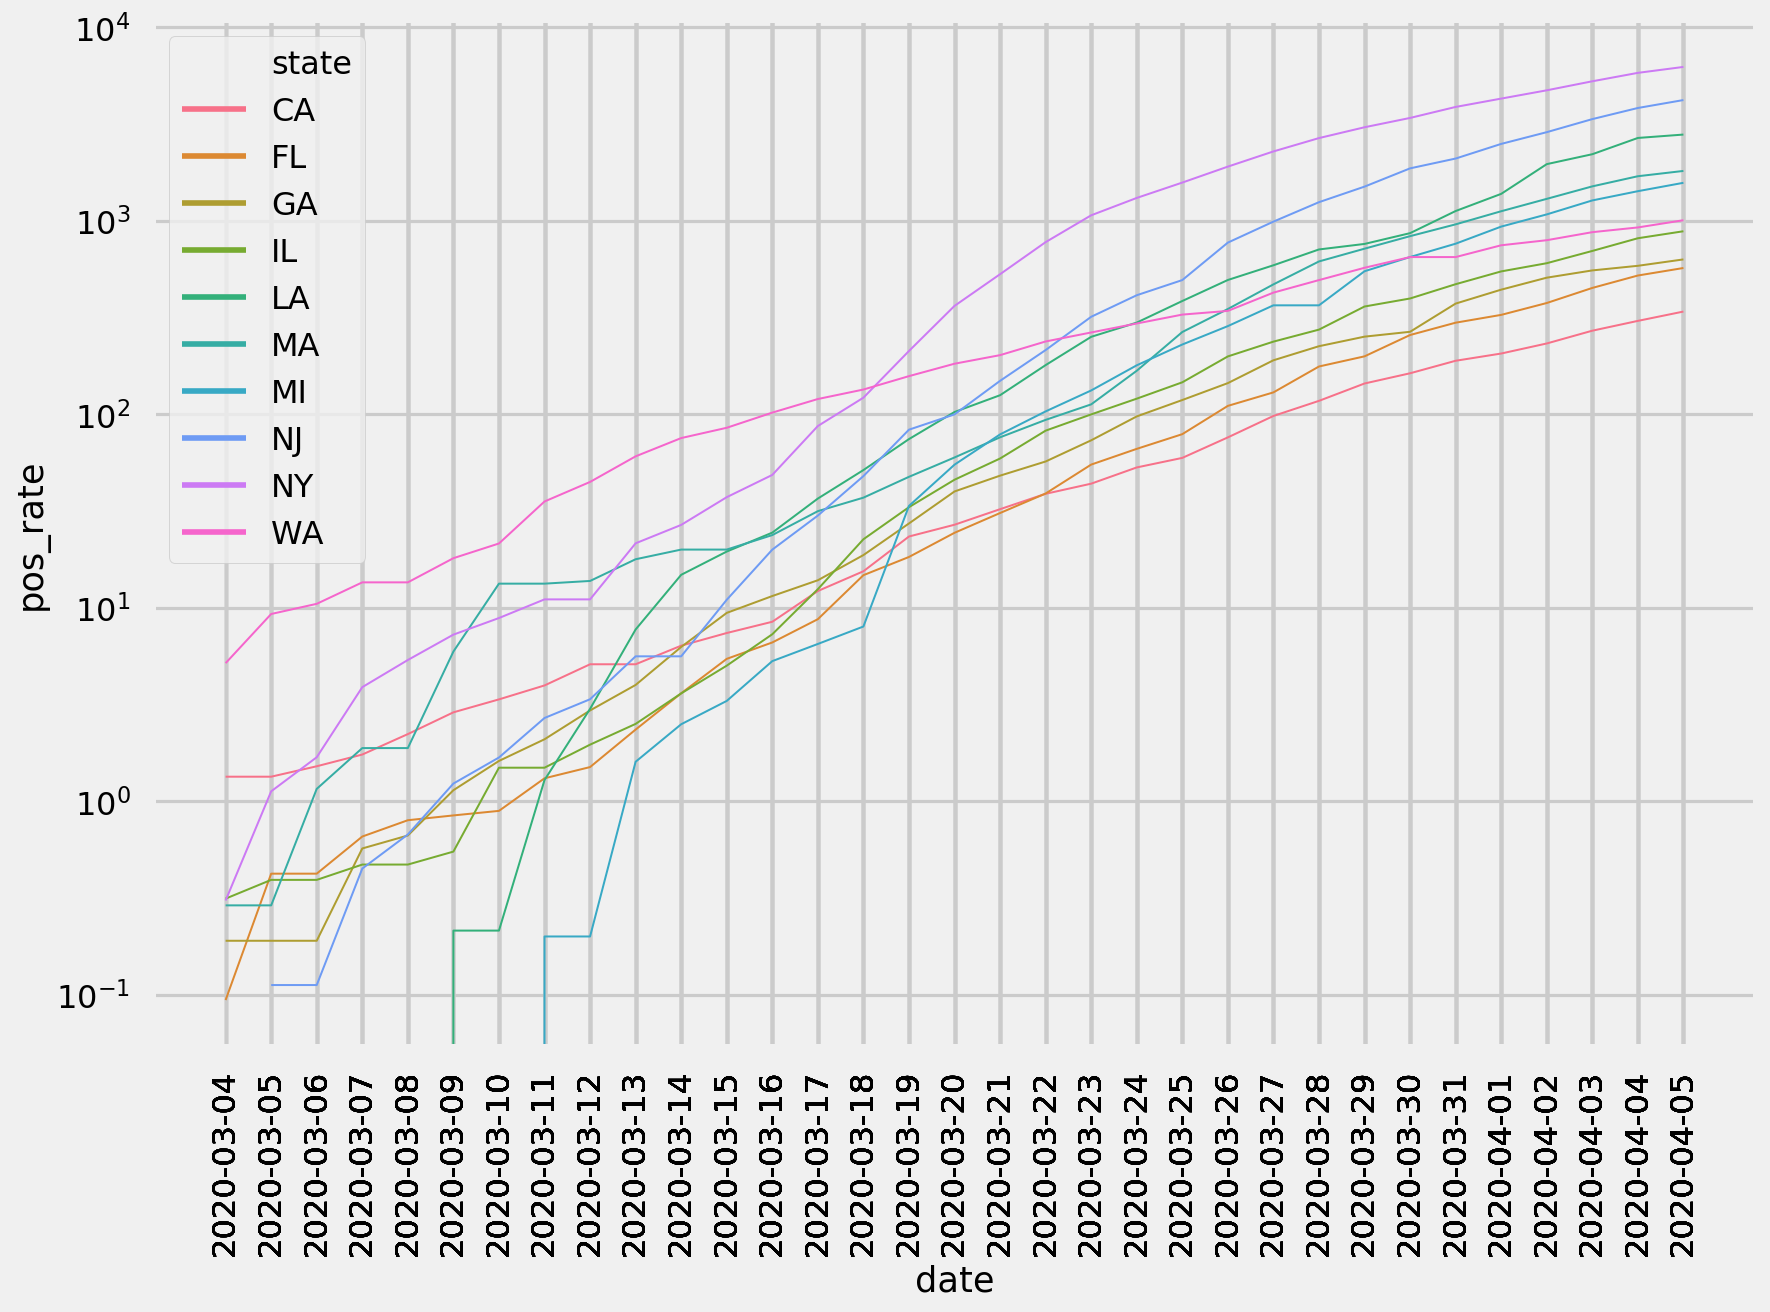

In [21]:
ax = sns.lineplot(x="date", y="pos_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Hospitalized Per Million People

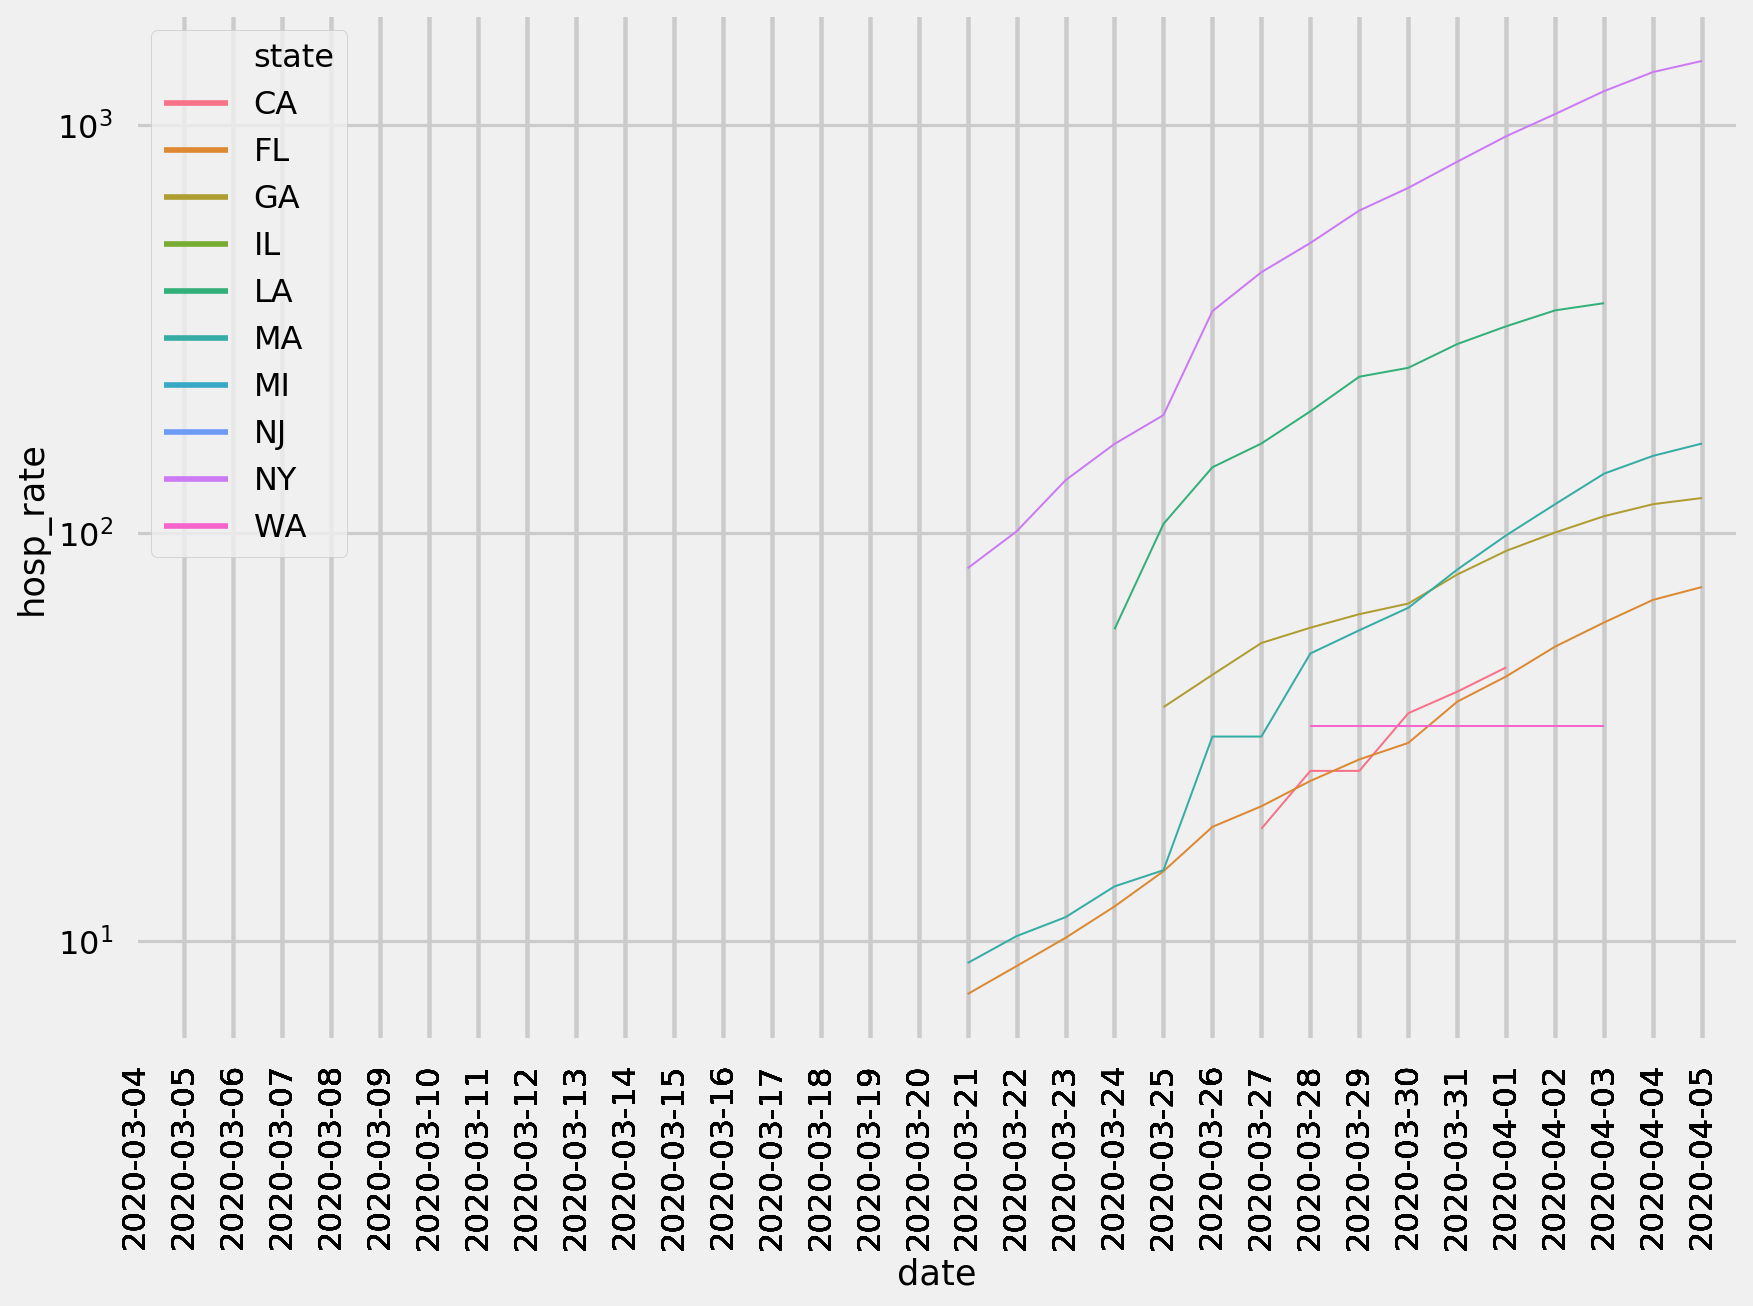

In [22]:
ax = sns.lineplot(x="date", y="hosp_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths Per Million People

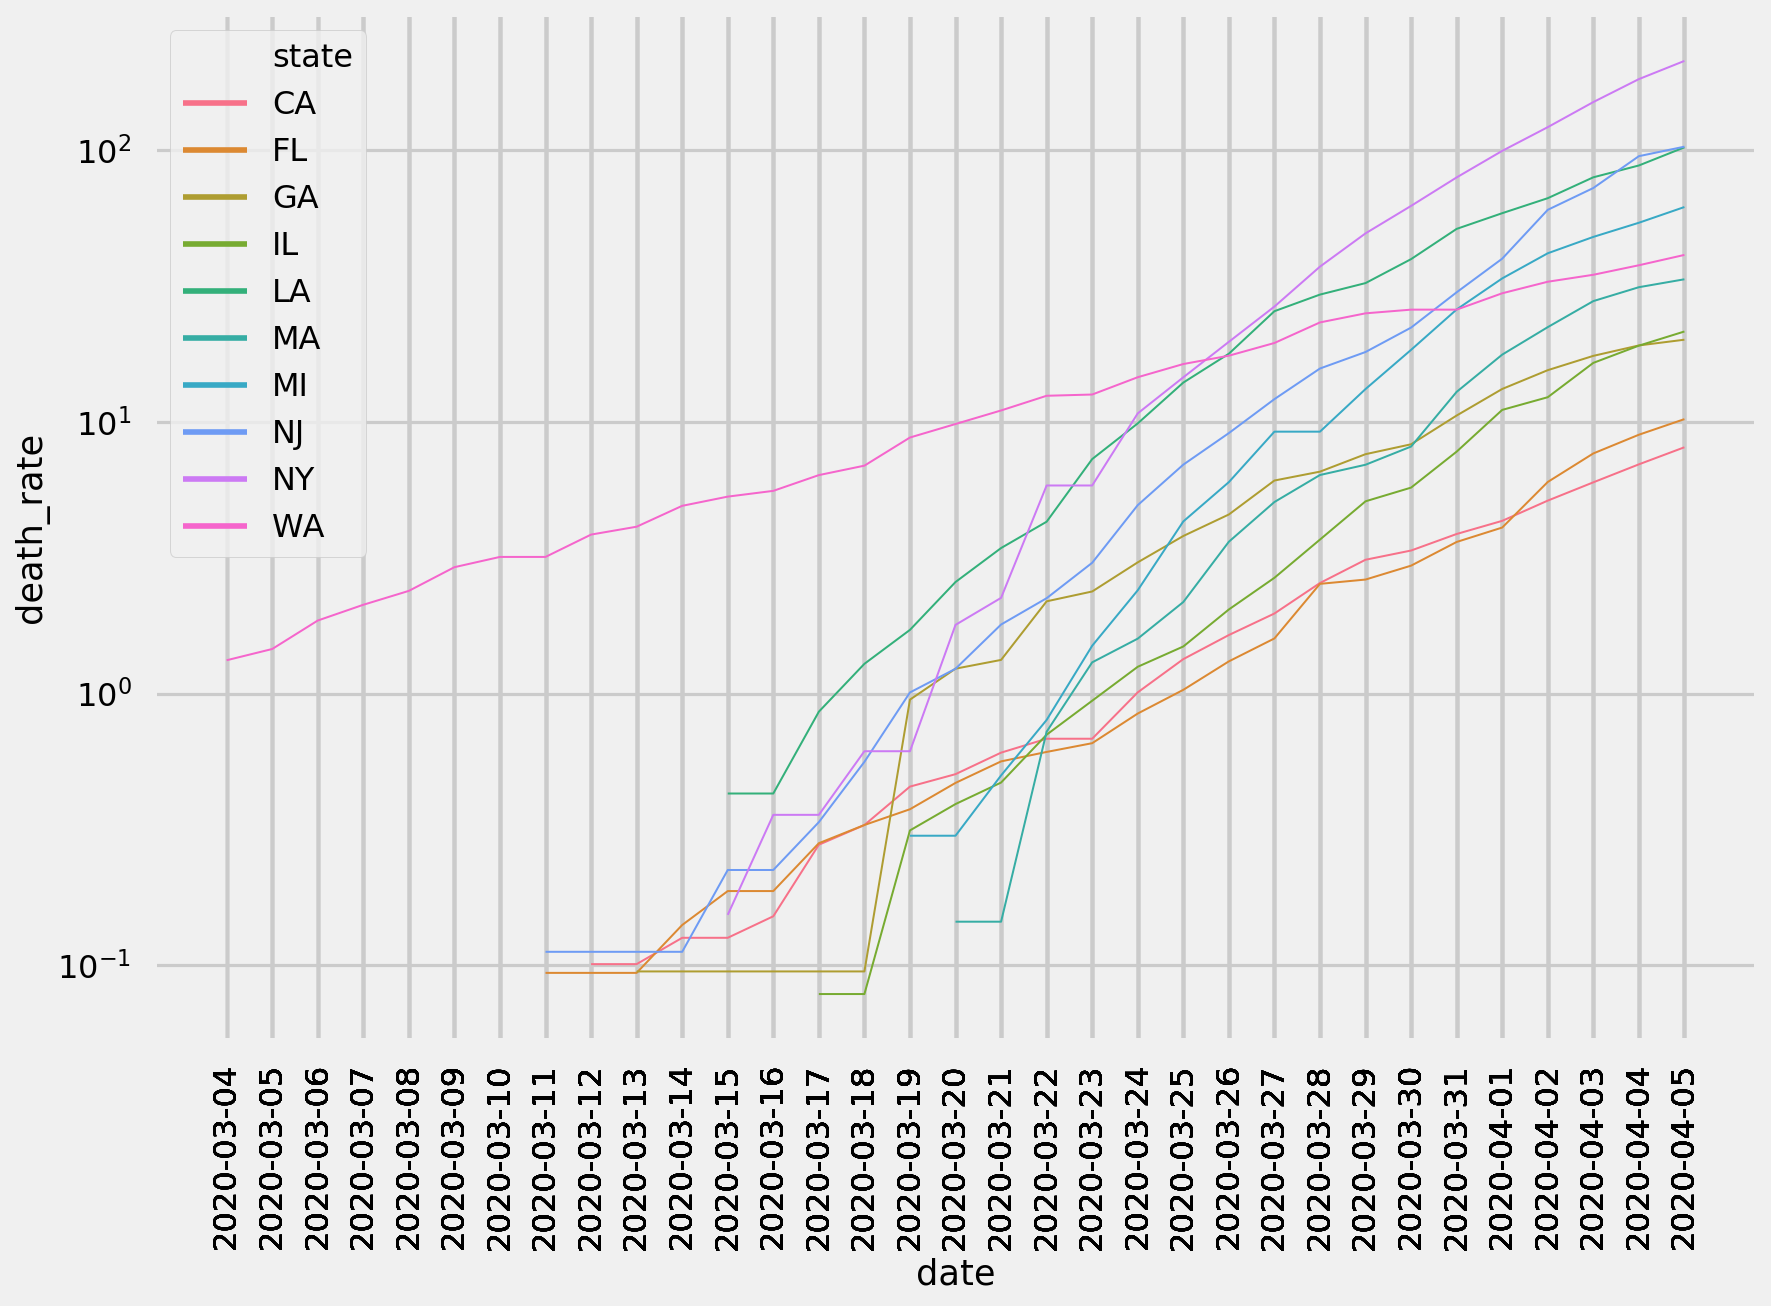

In [23]:
ax = sns.lineplot(x="date", y="death_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Tests Per Million People

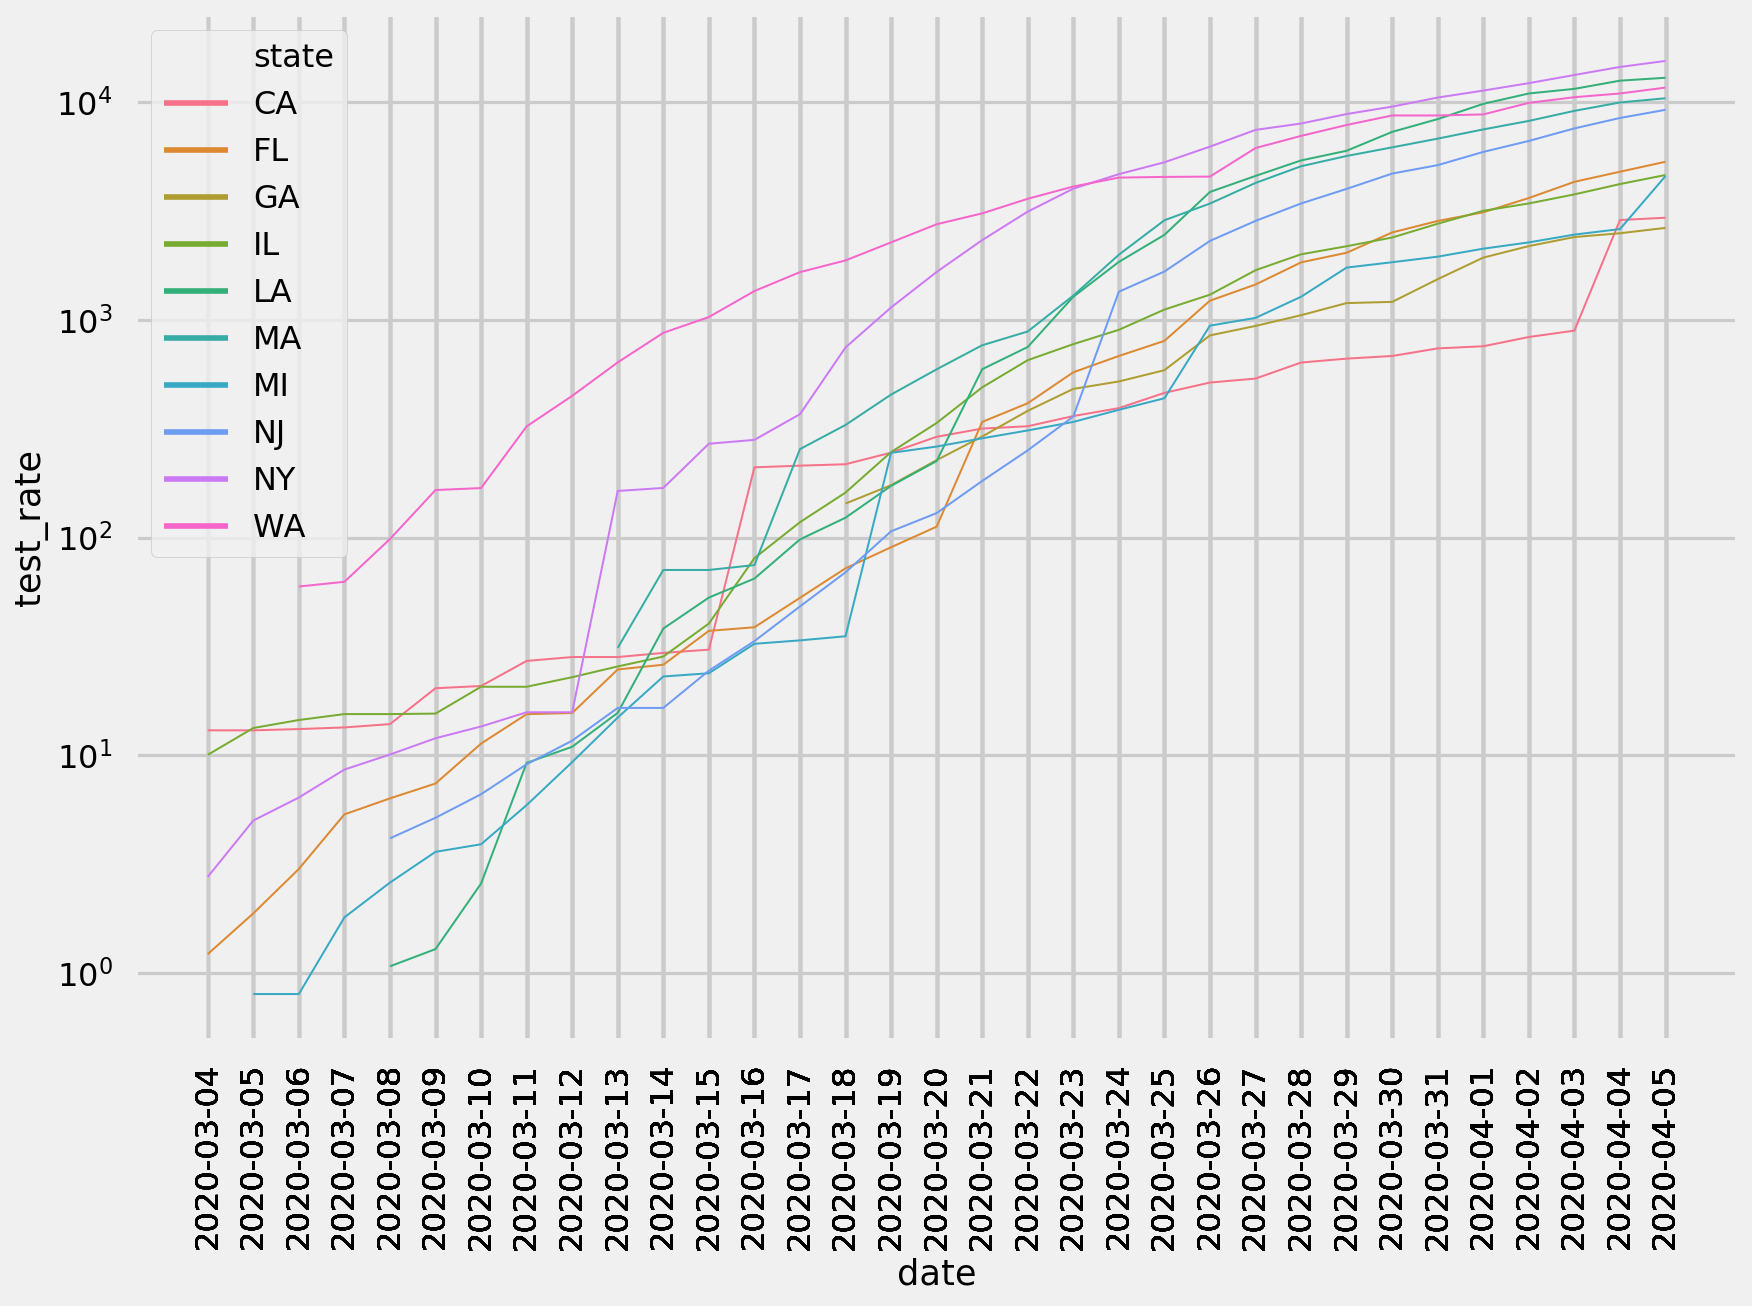

In [24]:
ax = sns.lineplot(x="date", y="test_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

In [25]:
df_states.query('date == @latest_date').sort_values(by='test_rate', 
                                                    ascending=False)[['state', 'test_rate']]

,state,test_rate
1067,NY,15468.056861
566,LA,12945.340085
1498,WA,11667.034477
1467,VT,10509.357352
596,MA,10422.406123
1405,UT,9772.532073
220,DC,9728.737072
972,NJ,9223.305330
349,HI,9120.085942
877,ND,8929.358473
